In [1]:
import networkx as nx
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from statistics import mean

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
num_nodes = 50
xs = [np.random.randint(100, 1000) for _ in range(num_nodes)]
ys = [np.random.randint(100, 1000) for _ in range(num_nodes)]

### Generate the distances 

In [4]:
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt(math.pow(x1-x2, 2) + math.pow(y1-y2, 2))

distance_matrix = np.array([
        distance((xs[i], ys[i]), (xs[j], ys[j])) for i in range(num_nodes) for j in range(num_nodes)
    ]).reshape(num_nodes,num_nodes)

distance_df = pd.DataFrame(distance_matrix)
distance_df.head(10)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,225.887140,531.944546,222.441003,853.961357,843.717962,194.257561,665.198467,464.449136,329.596723,...,826.898422,322.020186,359.489916,830.876645,563.968971,772.914614,707.800113,527.459003,609.308625,765.488080
1,225.887140,0.000000,338.540987,50.009999,659.655213,669.266016,54.378304,439.520193,396.161583,306.132324,...,614.961787,96.332757,418.743358,604.990083,382.020942,644.490496,501.681174,304.322198,413.303762,581.743070
2,531.944546,338.540987,0.000000,316.848544,323.303263,333.677988,344.280409,264.037876,301.240767,614.973983,...,554.176867,266.056385,495.552217,408.750535,55.659680,359.680414,181.024860,159.530561,77.369245,243.559028
3,222.441003,50.009999,316.848544,0.000000,640.101554,641.950154,28.284271,448.612305,347.570137,351.946019,...,644.215026,113.017698,372.339898,616.042206,355.607930,605.330488,487.984631,307.117241,393.513659,557.411876
4,853.961357,659.655213,323.303263,640.101554,0.000000,114.934764,667.582205,371.845398,521.107475,916.746421,...,628.491050,579.151966,753.400956,389.032132,291.343440,314.892045,170.414201,399.591041,246.732649,103.160070
5,843.717962,669.266016,333.677988,641.950154,114.934764,0.000000,667.835309,453.097120,461.039044,947.532585,...,727.396041,599.690754,696.017960,495.176736,287.250762,207.251055,234.386433,447.849305,267.262044,96.041658
6,194.257561,54.378304,344.280409,28.284271,667.582205,667.835309,0.000000,475.189436,358.949857,339.166626,...,664.648027,136.165341,365.410728,642.348815,382.058896,626.278692,516.117235,334.534004,421.118748,584.085610
7,665.198467,439.520193,264.037876,448.612305,371.845398,453.097120,475.189436,0.000000,562.737950,608.927746,...,296.978114,343.222960,735.227856,167.931534,301.943703,572.050697,219.804459,146.321564,249.323084,363.038565
8,464.449136,396.161583,301.240767,347.570137,521.107475,461.039044,358.949857,562.737950,0.000000,698.086671,...,843.095487,396.323101,235.002128,709.566769,279.692688,326.741488,448.539853,435.949538,346.716022,417.967702
9,329.596723,306.132324,614.973983,351.946019,916.746421,947.532585,339.166626,608.927746,698.086671,0.000000,...,645.263512,350.321281,668.629195,745.312015,665.868606,946.370435,747.800107,520.335469,681.105719,854.382818


### Draw the graph

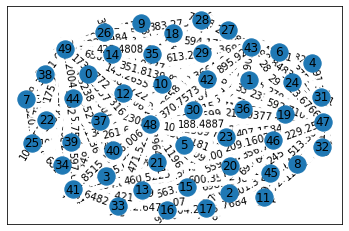

In [5]:
G = nx.Graph()
for u in distance_df.index:
    for v in distance_df.columns:
        G.add_edge(u, v, distance=distance_df.loc[u,v])
        
pos = nx.spring_layout(G)
edge_labels = {
    (r, c): round(distance_df.loc[r,c], 4) for r in distance_df.index for c in distance_df.columns if r != c and r > c
}
nx.draw_networkx(G, pos)
ret = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.7)

### ACO parameters

In [6]:
max_iterations = 100
num_ants = 50
tau_0 = (10/(num_nodes * mean(edge_labels.values()))) # initial pheromone concentration
tau_matrix = tau_0 * np.ones((num_nodes, num_nodes))
np.fill_diagonal(tau_matrix, 0)
tau_df = pd.DataFrame(tau_matrix)
eta_matrix= 1 / distance_matrix
eta_df = pd.DataFrame(eta_matrix)

rho = 0.05 # evaporation rate
alpha = 1 # pheromone exponential parameter
beta = 1 # desirability exponential parameter

### ACO functions

In [7]:
def roulette_wheel(probabilty_vector):
    cumulative_sum = np.cumsum(probabilty_vector)
    r = np.random.rand()
    return np.where(r <= cumulative_sum)[0][0]
    
def create_colony(graph, colony, num_ants, tau_matrix, eta_matrix, alpha, beta):
    num_nodes = len(graph.nodes)
    ant_tours = np.empty((0, num_nodes + 1), dtype=int)
    for i in range(num_ants):
        current_tour = []
        initial_node = random.randint(0, num_nodes-1)
        current_tour = [initial_node]
        
        for j in range(1, num_nodes):
            current_node = current_tour[-1]
            probabilty_all_nodes = tau_matrix[current_node,:]**alpha * (eta_matrix[current_node,:] ** beta)
            for node in current_tour:
                probabilty_all_nodes[node] = 0
            probabilty_all_nodes_sum = np.nansum(probabilty_all_nodes)
            probabilty_vector = probabilty_all_nodes / probabilty_all_nodes_sum
            
            next_node = roulette_wheel(probabilty_vector)
            current_tour.append(next_node)
        
        current_tour.append(current_tour[0])
        ant_tours = np.vstack((ant_tours, np.array(current_tour)))
    
    return ant_tours


def tour_distance(tour, graph):
    distance = 0
    for i in range(len(tour) - 1):
        distance += graph.edges[tour[i], tour[i+1]]['distance']
    return distance

def update_pheromones(tau_matrix, tour_and_distance):
    num_ants = tour_and_distance.shape[0]
    num_nodes = tour_and_distance.shape[1] - 1
    for i in range(num_ants):
        for j in range(num_nodes - 1):
            current_node = int(tour_and_distance[i, j])
            next_node = int(tour_and_distance[i, j + 1])
            tau_matrix[current_node, next_node] = tau_matrix[current_node, next_node] + (1/tour_and_distance[i, -1])
            tau_matrix[next_node, current_node] = tau_matrix[next_node, current_node] + (1/tour_and_distance[i, -1])

    

### Main loop of ACO

In [8]:
best_path_length = float('inf')
all_solutions = np.empty((0, 2))

for i in range(0, max_iterations):
    # create the tours for all ants
    tours = create_colony(G, [], num_ants, tau_matrix, eta_matrix, alpha, beta)

    # calculate the tour length for each tour
    tour_lengths = np.array([tour_distance(tours[row,:], G) for row in range(tours.shape[0])]).reshape(num_ants, 1)
    tour_and_distance = np.hstack((tours, tour_lengths))
    
    # find the best ant (queen)
    current_best_length = np.amin(tour_and_distance[:, -1])
    current_best_ant = np.where(tour_and_distance[:, -1] == current_best_length)[0][0]
    current_best_tour = tour_and_distance[current_best_ant, :-1]
    
    if current_best_length < best_path_length:
        best_path_length = current_best_length
        best_tour = current_best_tour
        
    # update the pheromone matrix
    update_pheromones(tau_matrix, tour_and_distance)
    
    # evaporation
    tau_matrix = (1 - rho) * tau_matrix

    # capture the results
    all_solutions = np.vstack((all_solutions, np.array([i, current_best_length])))

### Shortest Path Length

In [9]:
f'Shorest path length is {best_path_length}'

'Shorest path length is 6066.830516343498'

### Plot the best result of each iteration

Text(0, 0.5, 'Shortest Path Length')

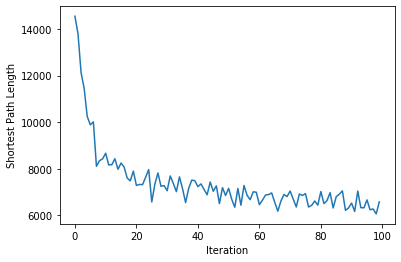

In [10]:
plt.plot(all_solutions[:, 0], all_solutions[:, 1])
plt.xlabel('Iteration')
plt.ylabel('Shortest Path Length')